# Introduction to Neural Networks

Based off of the lab exercises from deeplearning.ai, using public datasets and personal flair.

## Objectives
- Build the general architecture of a learning algorithm, including:
    - initializing parameters
    - calculating the cost function and its gradient
    - using an optimization algorithm
- Gather all three functions above into a main model function, in the right order.

## Import Packages

In [1]:
import os
import random
import re

import numpy as np
import matplotlib.pyplot as plt
import scipy

from PIL import Image
from scipy import ndimage
from sklearn.model_selection import train_test_split

%matplotlib inline

## Dataset

Data will be taken from Kaggle's [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) dataset.

From Kaggle's description:

>The train folder contains 25,000 images of dogs and cats. Each image in this folder has the label as part of the filename. The test folder contains 12,500 images, named according to a numeric id. For each image in the test set, you should predict a probability that the image is a dog (1 = dog, 0 = cat).

Steps to reproduce:
- preprocess train and validation set
    - (optional) select subset of training set
    - resize images to all be the same (64x64)
    - flatten images
- build logistic regression model as a single-layer neural network
    - initialize weight matrix
    - write forward and backprop functions, defining the log loss cost function
    - optimize learning

In [67]:
TRAIN_PATH = 'C:/Users/JYDIW/Documents/kaggle-datasets/dogs-vs-cats-redux-kernels-edition/train/'
TEST_PATH = 'C:/Users/JYDIW/Documents/kaggle-datasets/dogs-vs-cats-redux-kernels-edition/test/'

ROWS = 128
COLS = 128
CHANNELS = 3

m_train = 800
m_val = 200
m_total = m_train + m_val

all_train_dogs = [TRAIN_PATH+f for f in os.listdir(TRAIN_PATH) if 'dog' in f]
all_train_cats = [TRAIN_PATH+f for f in os.listdir(TRAIN_PATH) if 'cat' in f]

all_train_images = random.sample(all_train_dogs, m_total//2) + random.sample(all_train_cats, m_total//2)
random.shuffle(all_train_images)

train_images, val_images = train_test_split(all_train_images, test_size=m_val)

# all_test_images = [TEST_PATH+f for f in os.listdir(TEST_PATH)]
# test_images = random.sample(all_test_images, m_test)

In [68]:
def read_image(image_path, as_array=False):
  img = Image.open(image_path)
  if as_array:
    return np.asarray(img.resize((COLS, ROWS)))
  return img.resize((COLS, ROWS))

def resize_images(images):
  count = len(images)
  data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
  for i, file in enumerate(images):
    img = read_image(file, as_array=True)
    data[i] = img
    if (i+1)%250 == 0:
      print(f'Processed {i+1} of {count}')
  return data

(128, 128, 3)


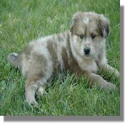

In [69]:
print(read_image(train_images[0], as_array=True).shape)
read_image(train_images[0])

In [70]:
train_images_resized = resize_images(train_images)
val_images_resized = resize_images(val_images)

Processed 250 of 800
Processed 500 of 800
Processed 750 of 800


In [71]:
def generate_labels(images):
  labels = np.zeros((1, np.array(images).shape[0]), dtype=np.uint8)
  for i, img in enumerate(images):
    if re.findall('.+\/(\w+)\.\d+\.jpg', img)[0] == 'dog':
      labels[0][i] = 1
#     else:
#       labels[0][i] = 0
  return labels

In [72]:
y_train = generate_labels(train_images)
y_val = generate_labels(val_images)

In [74]:
def flatten_and_normalize_images(images):
  return images.reshape(images.shape[0], -1).T / 255

In [75]:
X_train = flatten_and_normalize_images(train_images_resized)
X_val = flatten_and_normalize_images(val_images_resized)

In [76]:
print(X_train.shape)
print(y_train.shape)

(49152, 800)
(1, 800)


## Building the Algorithm

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

In [15]:
def sigmoid(z):
  return 1 / (1 + np.exp(-1 * z))

In [16]:
def initialize_with_zeros(dim):
  w = np.zeros((dim, 1))
  b = 0
  return w, b

In [54]:
def negative_log_likelihood(A, y, m):
  J = -1 * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A)) / m
  return J

In [55]:
def propagate(w, b, X, y):
  m = X.shape[1]
  A = sigmoid(np.dot(w.T, X) + b)
  cost = negative_log_likelihood(A, y, m)

  dw = np.dot(X, (A - y).T) / m
  db = np.sum(A - y) / m

  cost = np.squeeze(cost)
  grads = {"dw": dw, "db": db}

  return grads, cost


In [59]:
def optimize(w, b, X, y, num_iterations, learning_rate, verbose=False):
  costs = []
  
  for i in range(num_iterations):
    grads, cost = propagate(w, b, X, y)
    dw = grads['dw']
    db = grads['db']
    
    w -= learning_rate * dw
    b -= learning_rate * db
    
    if i % 100 == 0:
      costs.append(cost)
      if verbose:
        print(f'cost after iteration {i}: {cost}')
  
  params = {'w': w, 'b': b}
  grads = {'dw': dw, 'db': db}
  
  return params, grads, costs

In [43]:
def predict(w, b, X):
  m = X.shape[-1]
  y_pred = np.zeros((1, m))
  w = w.reshape(X.shape[0], 1)
  
  A = sigmoid(np.dot(w.T, X) + b)
  
  for i in range(A.shape[1]):
    y_pred[0][i] = (A[0][i] > 0.5)
    
  return y_pred

In [21]:
def model(X_train, y_train, X_val, y_val, num_iterations=2000, learning_rate=0.5, verbose=False):
  w, b = initialize_with_zeros(X_train.shape[0])
  params, grads, costs = optimize(w, b, X_train, y_train, num_iterations, learning_rate, verbose)
  
  w = params['w']
  b = params['b']
  
  y_pred_train = predict(w, b, X_train)
  y_pred_val = predict(w, b, X_val)
  
  print(f'train accuracy: {(100 - np.mean(np.abs(y_pred_train - y_train)) * 100)}')
  print(f'test accuracy: {(100 - np.mean(np.abs(y_pred_val - y_val)) * 100)}')


  d = {"costs": costs,
       "y_prediction_test": y_pred_val, 
       "y_prediction_train" : y_pred_train, 
       "w" : w, 
       "b" : b,
       "learning_rate" : learning_rate,
       "num_iterations": num_iterations}
  
  return d

In [78]:
m = model(X_train, y_train, X_val, y_val, 2000, 0.005, True)

cost after iteration 0: 0.6931471805599452
cost after iteration 100: 3.454169192861785
cost after iteration 200: 4.19750334914926
cost after iteration 300: 4.1188392553789885
cost after iteration 400: 4.039392025305311
cost after iteration 500: 3.9681554335302214
cost after iteration 600: 3.8840734705378397
cost after iteration 700: 3.793686363109777
cost after iteration 800: 3.703834827497441
cost after iteration 900: 3.6200087518981126
cost after iteration 1000: 3.542935255901365
cost after iteration 1100: 3.470934366372168
cost after iteration 1200: 3.4007262730644823
cost after iteration 1300: 3.3279209612208023
cost after iteration 1400: 3.250476606041328
cost after iteration 1500: 3.1700452565226076
cost after iteration 1600: 3.088383833332973
cost after iteration 1700: 3.0062164166896674
cost after iteration 1800: 2.923499855149795
cost after iteration 1900: 2.8399148978577227
train accuracy: 62.375
test accuracy: 56.0


## Adding Layers to the Model

Steps to reproduce:
- Initialize the parameters for a two-layer network and for an $L$-layer neural network.
- Implement the forward propagation module.
     - Complete the LINEAR part of a layer's forward propagation step (resulting in $Z^{[l]}$).
     - We give you the ACTIVATION function (relu/sigmoid).
     - Combine the previous two steps into a new [LINEAR->ACTIVATION] forward function.
     - Stack the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer $L$). This gives you a new L_model_forward function.
- Compute the loss.
- Implement the backward propagation module (denoted in red in the figure below).
    - Complete the LINEAR part of a layer's backward propagation step.
    - We give you the gradient of the ACTIVATE function (relu_backward/sigmoid_backward) 
    - Combine the previous two steps into a new [LINEAR->ACTIVATION] backward function.
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally update the parameters.

[0.6931471805599454]